In [1]:
%config IPCompleter.greedy=True


# Adapting the PiWind model with new flood vulnerability curves

This Jupyter notebook, originally downloaded as part of the PiWind model now includes additional code to produce new vulnerability matrices to use in the model. The new matrices model building vulnerability to flood hazards. 

Below is a broad outline of the notebook structure followed by a high-level summary of the results.

- Flood depth observations are combined with a pre-existing flood HAZUS vulnerability curve to generate synthetic loss data
- This loss data is then used to produce a vulnerability matrix that can be run within the PiWind model
- AALs (average annual losses) are calculated using both the new and original vulnerability matrices


### Summary of results and interpretation

With all other modelling inputs kept equal, the AAL produced using the new flood vulnerability matrix produced a Ground Up AAL of around £600,000. This was about <b>4 times higher than the AAL calculted using the original PiWind vulnerabilty matrix</b> (~  £150,000).

Losses associated with use of the flood vulnerability are higher because this matrix models higher losses at relatively low hazard intensities which occur much more frequently in PiWind's stochastic event set.

The same analysis was run in the Oasis user interface (with the PiWind vulnerability matrix) and the AAL was roughly double that calculated in this notebook. This is likely due to the fact that the default behaviour of the PiWind model is to run each of its 365 unique wind hazard footrprints twice, whilst in this notebook we only modelled damage from each footprint once.



In [2]:
# note that this analysis was run in Python version 3.10 - oasis_lmf only runs on versions 3.8 - 3.10

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import math
import numpy as np
import json
import seaborn as sns
import folium
import os
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.offsetbox import AnchoredText

import random
from scipy.stats import truncnorm

## First read in and explore the provided flood depth data

In [3]:
gdf = gpd.read_file('hiring-exercises-analytics-2023-main/senior_catastrophe_modeller/data/sample_pif_2020_2022.geojson')
gdf.head()

,index,fid,depth_meters_2020,depth_meters_2021,depth_meters_2022,geometry
0,5568,5569,0.289884,0.271908,0.791602,POINT (153.29549 -28.71314)
1,18566,18567,0.970188,0.711293,0.898242,POINT (153.32418 -28.82200)
2,14858,14859,0.064305,0.775006,0.936042,POINT (153.30009 -28.81079)
3,3415,3416,0.564557,0.368093,0.296670,POINT (153.18195 -28.52975)
4,21385,21386,0.560100,0.460904,0.436157,POINT (153.25483 -28.90343)


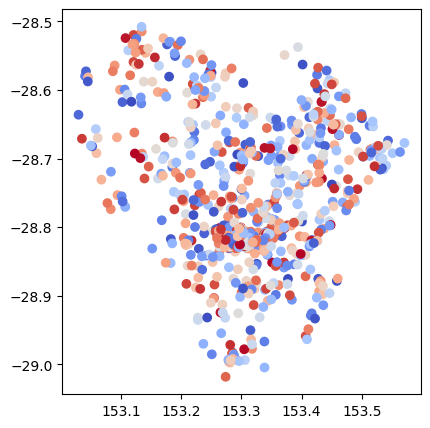

In [8]:
# quickly look at the flood depth data from one year on a map

# Set column to be used for color scale
column = 'depth_meters_2022'

cmap = 'coolwarm'
fig, ax = plt.subplots(figsize=(5, 5)) # set figsize as desired
gdf.plot(column=column, cmap=cmap, ax=ax)
plt.show()

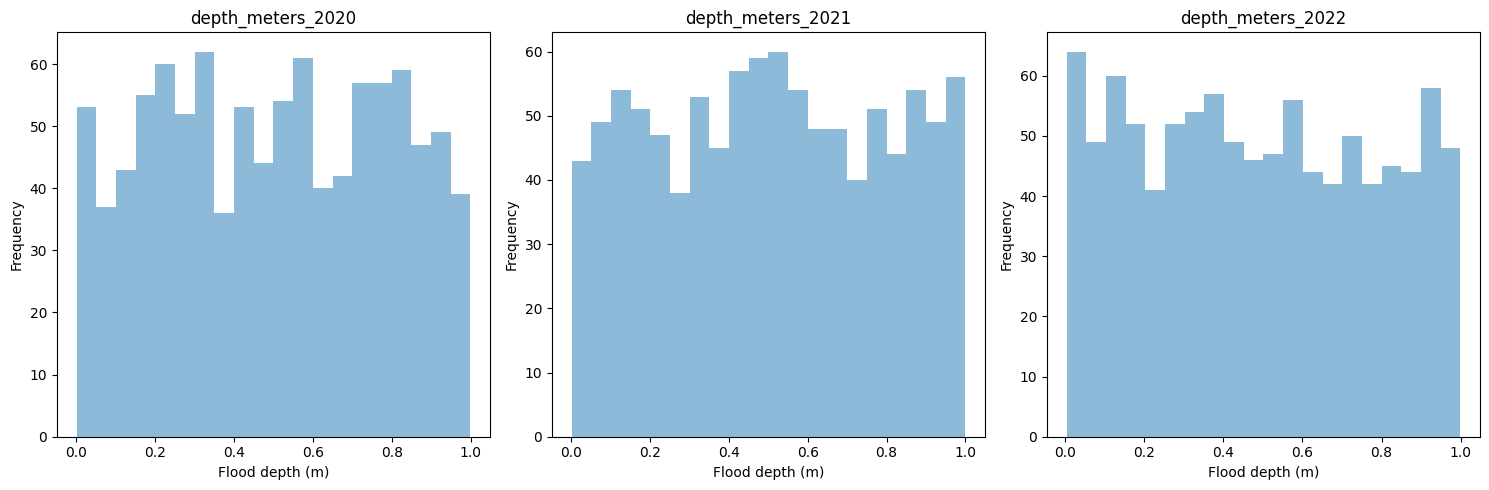

In [9]:
# make histograms of depth data to check if differnt years display similar distributions
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

# Set column names to use as input data
cols = gdf.columns[2:5]

for i, col in enumerate(cols):
    axs[i].hist(gdf[col], bins=20, alpha=0.5)
    axs[i].set_xlabel('Flood depth (m)')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

In [10]:
# the depth data different years appear to be fairly similar all ranging from 0.0-1.0 
# let's pivot all years of depth data into single column 
# so we can use these observations to generate synthetic damage data
gdfm = gdf.reset_index()
gdfm= pd.melt(gdf, id_vars='index', value_vars=['depth_meters_2020', 'depth_meters_2021', 'depth_meters_2022'],
             value_name='depth')
gdfm.head()

,index,variable,depth
0,5568,depth_meters_2020,0.289884
1,18566,depth_meters_2020,0.970188
2,14858,depth_meters_2020,0.064305
3,3415,depth_meters_2020,0.564557
4,21385,depth_meters_2020,0.560100


## Generate reasonable damage ratios for each flood depth measurement

To develop a new vulnerability curve for the the PiWind model we need to bin our available depth data into 29 bins because the PiWind vulnerability curves are set up with 29 intensity bins used to characterise windpseeds.

For each intensity bin, we can assign a mean damage ratio (MDR) based on exisitng vulnerabilty curves.  Then for each ICEYE flood depth observation we can generate a synthetic distribution of damage ratios that surround the MDR. 

This will capture a degree of uncertainty whilst generally increasing losses as hazard intensities increase.


In [11]:
# check maximum hazard intensity as this will control the value of the highest bin
print(max(gdfm['depth']), 'maximum hazard intensity')

# set number of bins - we want 29 labels and there must be one more labels than there are bins
n_bins = 29

# create bins 
bins = list(np.arange(0.0,1.01,(1/(n_bins))))
print(len(bins), 'bins')

# create ID 'labels' for cut function
labels = list(range(1,(n_bins+1)))
print(len(labels), 'labels')

0.9996560188786597 maximum hazard intensity
30 bins
29 labels


In [12]:
# confirm our largest bin contains the maximum depth value
max(bins) > max(gdfm['depth'])

True

In [13]:
# categorise each depth measurement into one of the intensity bins
gdfm['intensity_bin'] = pd.cut(gdfm['depth'], bins = bins, labels = labels)
gdfm.head()

,index,variable,depth,intensity_bin
0,5568,depth_meters_2020,0.289884,9
1,18566,depth_meters_2020,0.970188,29
2,14858,depth_meters_2020,0.064305,2
3,3415,depth_meters_2020,0.564557,17
4,21385,depth_meters_2020,0.560100,17


30 intensity bins
30 mdr bins
29 mdr labels


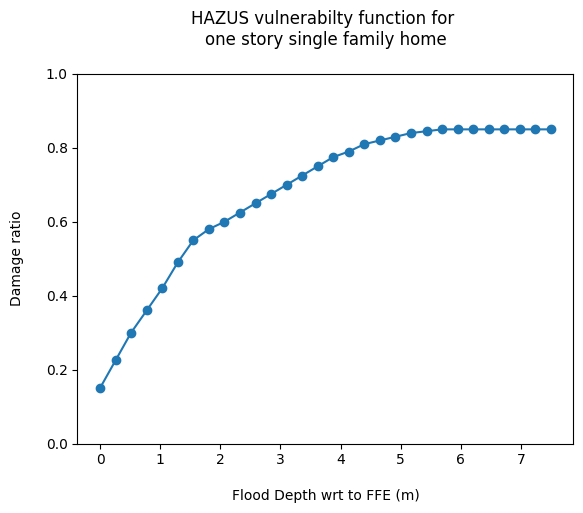

In [14]:
# define flood vulnerability curve from HAZUS 
# FEMA. 2009. HAZUS-MH MR4 flood model technical manual, mitigation division. Washington, DC: FEMA.

# one story single family home - building structure damage
# assume our flood damage data is measured in terms of first floor elevation (FFE) because all values are positive
# so our curve starts from 0 when in reality the curve goes from -2 m (below FFE) up to ~7.5 m above FFE
hazus_intensity = list(np.arange(0,7.6,7.5/n_bins))
print(len(hazus_intensity), 'intensity bins')

# hardcode 30 mean damage ratio associated with each flood depth - based on visual inspection of the curve
mdr = [0.15,0.225,0.3,0.36,0.42,0.49,0.55,0.58,0.6,0.625,0.65,0.675,0.7,0.725,0.75,0.775,0.79,0.81,0.82,0.83,0.84,0.845,0.85,0.85,0.85,0.85,0.85,0.85,0.85,0.85]
print(len(mdr), 'mdr bins')

# set MDR labels with one less label than there are bins - dropping final MDR
mdr_labels = mdr[0:-1]
print(len(mdr_labels), 'mdr labels')

# visualise curve
plt.plot(hazus_intensity, mdr)
plt.scatter(hazus_intensity, mdr)
plt.title('HAZUS vulnerabilty function for \none story single family home\n')
plt.xlabel('\nFlood Depth wrt to FFE (m)')
plt.ylabel('Damage ratio\n')
plt.ylim(0,1)
plt.show()

(0.0, 1.0)

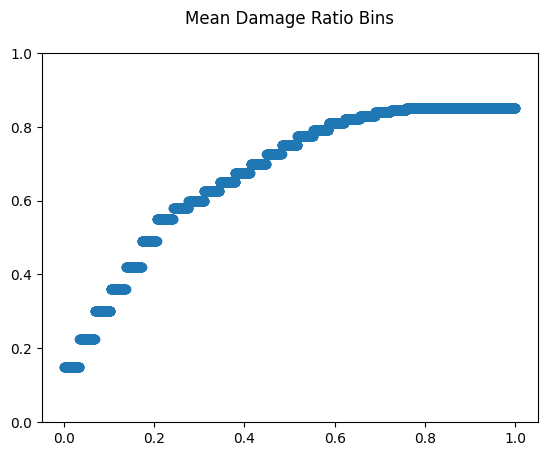

In [15]:
# Bin each flood intensity depth from geojson to associate with an assumed mean damage ratio
df = gdfm

df['mdr'] = pd.cut(gdfm['depth'], bins = bins, labels = mdr_labels, ordered = False)

# visualise this
plt.scatter(gdfm['depth'], gdfm['mdr'])
plt.title('Mean Damage Ratio Bins\n')
plt.ylim(0,1)


In [16]:
# use a truncated normal distribution to represent unceratinty in loss surrounding the mean damage ratio 
# create a column called 'dr' for the newly sampled damage ratios
df['dr'] = np.nan

# set uncertainty bounds for the truncated normal distribution 
# 30% uncertainty typical in simplistic vulnerability studies without underlying empirical data
lower = -0.15
upper = 0.15

# set seed for consistent overvations - upon inspection this doesn't seem to work as I thought it would...
# fortunately we have a fairly large sample of observations so the overall distribution will not change drastically
# from one run to the next - but would need to fix this in future for model validation purposes
random.seed(1)

# for each mdr value add a random value from a truncated normal distribution
for i in range(len(df)):
    mdr = df.loc[i, 'mdr']
    std = 0.3
    a = (lower - mdr) / std
    b = (upper - mdr) / std
    r = truncnorm(a, b, loc=mdr, scale=std).rvs()
    df.loc[i, 'dr'] = mdr + r

df.head()

,index,variable,depth,intensity_bin,mdr,dr
0,5568,depth_meters_2020,0.289884,9,0.600,0.715374
1,18566,depth_meters_2020,0.970188,29,0.850,0.841130
2,14858,depth_meters_2020,0.064305,2,0.225,0.202766
3,3415,depth_meters_2020,0.564557,17,0.790,0.785139
4,21385,depth_meters_2020,0.560100,17,0.790,0.885063


True
True


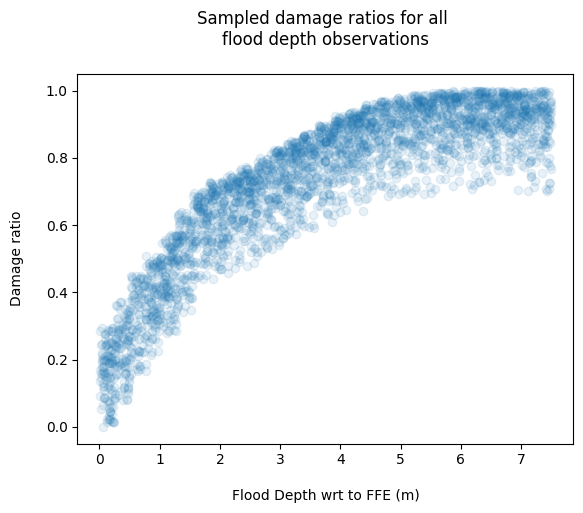

In [17]:
# visualise the newly sampled damge ratios
plt.scatter(df['depth']*max(hazus_intensity), df['dr'], alpha=0.1) # multiply our maximum flood depth of 1 by the HAZUS max flood depth
plt.title('Sampled damage ratios for all \nflood depth observations\n')
plt.xlabel('\nFlood Depth wrt to FFE (m)')
plt.ylabel('Damage ratio\n')

# and confirm all values are within 0-1 - assuming loss cannot be negative or greater than 100%
print(min(df['dr']) >= 0)
print(max(df['dr']) <= 1)

## Create new flood vulnerability input for the PiWind model

Now that we have generated a damage ratio for each flood depth measurement, we can use this to modify the existing PiWind vulnerabilty matrices.

For simplicity lets use the existing Damage Bin Dictionary to relate damage ratio values to loss fractions and simply modify the probabilities in the vulnerabilty matrices that feed into this dictionary. This dictionary groups damage ratios into 12 damage bin indices so we must group our damage ratios (0.0-1.0) into 12 different bins.

We will then group our observations according to their intensity bins and use the proportion of observations within each damage bin index within each intensity bin to calculate the probability of a given level of damage being reached for a given intensity.

Simple right?! Lets get to it.

In [18]:
# read in a copy of the damage bin dictionary and use it to bin our damage ratios

dbd = pd.read_csv('additional_inputs/damage_bin_dict_copy.csv')

dbd.head(12)

,bin_index,bin_from,bin_to,interpolation,interval_type
0,1,0.0,0.0,0.00,1203
1,2,0.0,0.1,0.05,1200
2,3,0.1,0.2,0.15,1202
3,4,0.2,0.3,0.25,1202
4,5,0.3,0.4,0.35,1202
5,6,0.4,0.5,0.45,1202
6,7,0.5,0.6,0.55,1202
7,8,0.6,0.7,0.65,1202
8,9,0.7,0.8,0.75,1202
9,10,0.8,0.9,0.85,1202


In [19]:
# use the bin_to column to define our bin ranges
damage_bins = dbd['bin_to'].tolist()

# insert first value from the bin_from column at the beginning of this list - so we have the full set of bins
my_insert = dbd['bin_from'].iloc[0]

damage_bins.insert(0,my_insert)

# the pd.cut function does not allow duplicate bin values 
# so lets slightly increase the size of the second bin
damage_bins[1] = damage_bins[1]+0.01

# and make the second to last bin slightly smaller 
# so that extremely small or high damage ratios can have 0 or 100% damage from the most extreme bins
damage_bins[-2] = damage_bins[-2]-0.05

print(damage_bins)
print(len(damage_bins))

# use the bin_index column to define our bin labels
db_labels = dbd['bin_index'].tolist()
print(db_labels)
print(len(db_labels))

[0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]
13
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
12


In [20]:
max(gdfm['dr'])

0.9999719854190733

In [21]:
# categorise each damage ratio into one of the damage bins
gdfm['damage_bin_id'] = pd.cut(gdfm['dr'], bins = damage_bins, labels = db_labels, duplicates='raise')
gdfm.head()
df.head()

,index,variable,depth,intensity_bin,mdr,dr,damage_bin_id
0,5568,depth_meters_2020,0.289884,9,0.600,0.715374,9
1,18566,depth_meters_2020,0.970188,29,0.850,0.841130,10
2,14858,depth_meters_2020,0.064305,2,0.225,0.202766,4
3,3415,depth_meters_2020,0.564557,17,0.790,0.785139,9
4,21385,depth_meters_2020,0.560100,17,0.790,0.885063,10


In [22]:
# now that we have binned our damage ratios into damage bin IDs we can calculate the probability of each bin occurring 
# for a given hazard intensity bin

# select required columns, group and calculate probability of each damage bin occuring for each intensity bin
vdf = (gdfm.drop(['variable', 'index'], axis=1)
        .groupby(['intensity_bin', 'damage_bin_id'])
       # calculate number of rows for each group compared to the total number of rows for each intensity bin
        .apply(lambda x: x.assign(n_int_obs=len(x), n_dam_obs=len(x), probability=len(x)/len(gdfm.loc[gdfm['intensity_bin']==x.iloc[0]['intensity_bin']])) )
        .reset_index(level=[0,1], drop=True)
        .loc[:, ['intensity_bin', 'damage_bin_id', 'probability']]
        .drop_duplicates()
        .groupby('intensity_bin')
        .apply(lambda x: x.assign(check_p=sum(x['probability'])))
        .reset_index(level=0, drop=True)
       # sort rows so that correct vulnerability_id can be assigned in final step
        .sort_values(['intensity_bin', 'damage_bin_id']))

# create 12 replicas of the data as there are a total of 12 different building types available in the 
# PiWind model and we want to simply use our new vulnerability matrix for all of them 
n_rep = 12
d12 = pd.concat([vdf]*n_rep, ignore_index=True)

# tidy up the d12 dataframe so that it is a replica of the vulnerability matrices used in the Oasis LMF
v_mat = (d12.assign(vulnerability_id=np.ceil((d12.index+1)/len(vdf)))
           .reset_index(drop=True)
           .rename(columns={'intensity_bin': 'intensity_bin_id', 'vulnerability_id': 'vulnerability_id'})
           .reindex(columns=['vulnerability_id', 'intensity_bin_id', 'damage_bin_id', 'probability']))

#v_mat.to_csv('additional_inputs/my_v_mat.csv', index=False)
v_mat.head()

,vulnerability_id,intensity_bin_id,damage_bin_id,probability
0,1.0,1,1,0.008621
1,1.0,1,2,0.250000
2,1.0,1,3,0.405172
3,1.0,1,4,0.336207
4,1.0,2,2,0.051020


## Let us now compare our newly developed vulnerability matrix with the three that are used in PiWind.

The original three vulnerability matrices used for the wind peril (not storm surge) in the PiWind model are applied across residential, commercial and industrial building types. 

From the figure below we can see that the vulnerability patterns of the three types are fairly similar.

However, for the <b>residential and industrial</b> building types the level of damage across most hazard intensities has a <b>bimodal distribution</b>. i.e. for a given intensity relatively high or low damage ratios are more likely to occur than the mean damage ratio. 

This is typical of building vulnerability to wind gusts as <b>damage at a given intensity is likely to remain relatively low unless the building envelope is breached</b> (either by part of the roof or walls being ripped off, or more likely from a window or door being broken). If the building envelope is breached, then damage tends to be exacerbated as wind forces enter the building, likely causing more of the building envelope to be ripped away, and also allowing rain to damage the building. 

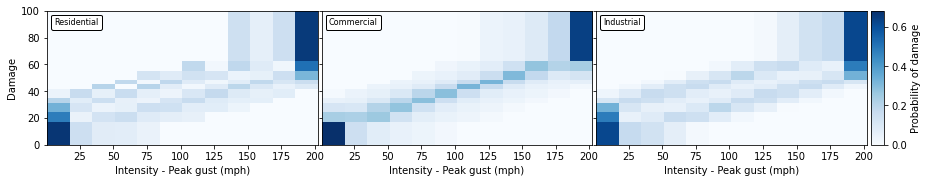

By comparison, the vulnerability matrix we have created (only one for all building types for simplicity) shows less variability in damage, particularly at relatively high hazard intensities.

Also note that to compare the two models we have used the PiWind Intensity Bin Dictionary. This means instead of the hazard being represented in terms of flood depth the our 29 intensity bin IDs are plotted according to peak wind gusts (i.e. <b>our 7.5 m maximum flood depth has been converted to the maximum modelled peak gust of 202.5 mph </b>).
    
If we were to model losses using our own Intensity Bin Dictionary (developed earlier in this notebook), <b>we would need to modify all of the the windstorm hazard intensities</b> (event footprints) by converting all windspeeds into their corresponding flood depths. 

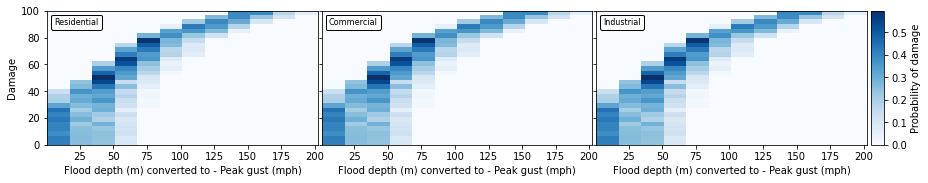

The code cells below were used to produce the plots above 

In [23]:
# we need to load the intensity and damage bin dictionaries from PiWind 
intensity_bin_dictionary = pd.read_csv("../model_data/PiWind/intensity_bin_dict.csv")
damage_bin_dictionary = pd.read_csv("../model_data/PiWind/damage_bin_dict.csv")

# and then load the PiWind vulnerability data
vulnerabilities = pd.read_csv("../model_data/PiWind/vulnerability_original_backup.csv")

/var/folders/m0/kkzly5c16x36wjqhty_t4zrh0000gn/T/ipykernel_25641/2463848698.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), vmin=vmin, vmax=vmax,


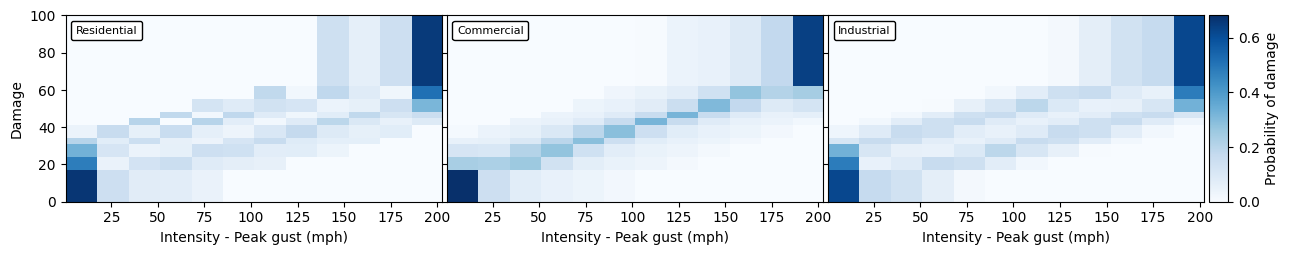

In [24]:
# visualise the PiWind matrices

vulnerabilities_with_hazard_and_damage = vulnerabilities.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_id', right_on='bin_index').merge(
    damage_bin_dictionary, how='inner',
    suffixes=["_i", "_d"], left_on='damage_bin_id', right_on='bin_index')

fig = plt.figure(figsize=(15,30))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

vmin = 0.0
vmax = max(vulnerabilities_with_hazard_and_damage.probability)
labels = ["Residential", "Commercial", "Industrial"]
for idx, ax in enumerate(grid):
    a = np.zeros((29, 12))
    for index, row in vulnerabilities_with_hazard_and_damage[
        vulnerabilities_with_hazard_and_damage.vulnerability_id == idx + 1].iterrows():
        a[int(row.bin_index_i-1), 11-int(row.bin_index_d-1)] = row.probability
    
    im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), vmin=vmin, vmax=vmax,
                   extent=(
                       min(intensity_bin_dictionary.interpolation), max(intensity_bin_dictionary.interpolation), 
                       min(damage_bin_dictionary.interpolation) * 100, max(damage_bin_dictionary.interpolation) * 100))

    at = AnchoredText(labels[idx],
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    ax.set_xlabel("Intensity - Peak gust (mph)")
    ax.set_ylabel("Damage")

grid[0].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Probability of damage")


plt.show()

/var/folders/m0/kkzly5c16x36wjqhty_t4zrh0000gn/T/ipykernel_25641/4159478692.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), vmin=vmin, vmax=vmax,


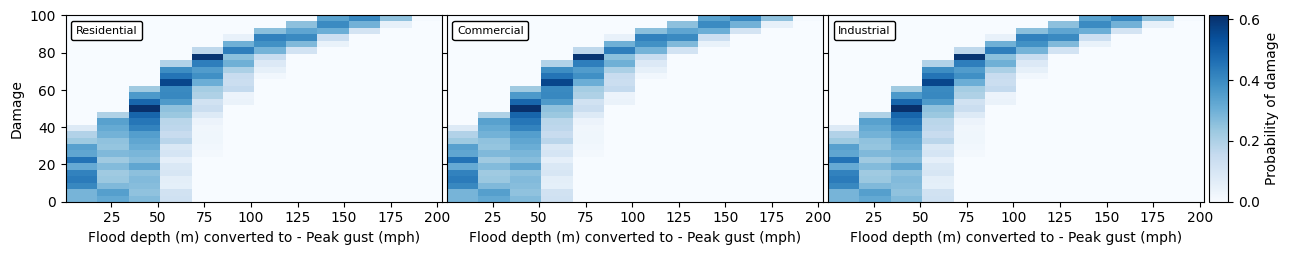

In [25]:
# visualise our ICEYE matrix using the same code but with our v_mat

vulnerabilities_with_hazard_and_damage = v_mat.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_id', right_on='bin_index').merge(
    damage_bin_dictionary, how='inner',
    suffixes=["_i", "_d"], left_on='damage_bin_id', right_on='bin_index')

fig = plt.figure(figsize=(15,30))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

vmin = 0.0
vmax = max(vulnerabilities_with_hazard_and_damage.probability)
labels = ["Residential", "Commercial", "Industrial"]
for idx, ax in enumerate(grid):
    a = np.zeros((29, 12))
    for index, row in vulnerabilities_with_hazard_and_damage[
        vulnerabilities_with_hazard_and_damage.vulnerability_id == idx + 1].iterrows():
        a[int(row.bin_index_i-1), 11-int(row.bin_index_d-1)] = row.probability
    
    im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), vmin=vmin, vmax=vmax,
                   extent=(
                       min(intensity_bin_dictionary.interpolation), max(intensity_bin_dictionary.interpolation), 
                       min(damage_bin_dictionary.interpolation) * 100, max(damage_bin_dictionary.interpolation) * 100))

    at = AnchoredText(labels[idx],
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    ax.set_xlabel("Flood depth (m) converted to - Peak gust (mph)")
    ax.set_ylabel("Damage")

grid[0].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Probability of damage")


plt.show()

## Loss Modelling

The matrix we have developed can now (most likely) be used in the PiWind model by overwriting the vulnerability matrix in the *..model_data/PiWind"* folder.

Unfortunately I encounterd an error whilst trying to get the model to run (even when using the deafult notebook prior to editing it). 

So in lieu of properly running the model, we can use the provided event footprints to sample hazard intensities and run the same set of hazard intensities against both sets of vulnerability matrices to see how changing the vulnerability might be expected influence loss results.

In [26]:
# read in the toy exposure file from PiWind
exp = pd.read_csv("../exposure_data/SourceLocOEDPiWind10.csv")

print(len(exp), 'Locations in total')

# Check the extent of the latitude and longitude columns
latitudes = exp['Latitude']
longitudes = exp['Longitude']

lat_min, lat_max = latitudes.min(), latitudes.max()
lon_min, lon_max = longitudes.min(), longitudes.max()

# Print the extent values
print("Latitude extent: {} to {}".format(lat_min, lat_max))
print("Longitude extent: {} to {}".format(lon_min, lon_max))

exp.head()

10 Locations in total
Latitude extent: 52.76695804 to 52.76724836
Longitude extent: -0.895473908 to -0.89524749


,PortNumber,AccNumber,LocNumber,IsTenant,BuildingID,CountryCode,Latitude,Longitude,StreetAddress,PostalCode,OccupancyCode,ConstructionCode,LocPerilsCovered,BuildingTIV,OtherTIV,ContentsTIV,BITIV,LocCurrency,OEDVersion
0,1,A11111,10002082046,1,1,GB,52.766981,-0.895470,1 ABINGDON ROAD,LE13 0HL,1050,5000,WW1,220000,0,0,0,GBP,2.0.0
1,1,A11111,10002082047,1,1,GB,52.766980,-0.895366,2 ABINGDON ROAD,LE13 0HL,1050,5000,WW1,790000,0,0,0,GBP,2.0.0
2,1,A11111,10002082048,1,1,GB,52.766978,-0.895248,3 ABINGDON ROAD,LE13 0HL,1050,5000,WW1,160000,0,0,0,GBP,2.0.0
3,1,A11111,10002082049,1,1,GB,52.766961,-0.895474,4 ABINGDON ROAD,LE13 0HL,1050,5000,WW1,30000,0,0,0,GBP,2.0.0
4,1,A11111,10002082050,1,1,GB,52.766958,-0.895353,5 ABINGDON ROAD,LE13 0HL,1050,5000,WW1,250000,0,0,0,GBP,2.0.0


All the PiWind locations (white circles below) appear to be quite close together. They are infact all in gridcell "6-4" - areaperil_id = 54. So let us sample all the hazard intensities from this cell. Apologies for using QGIS to figure this out quickly!

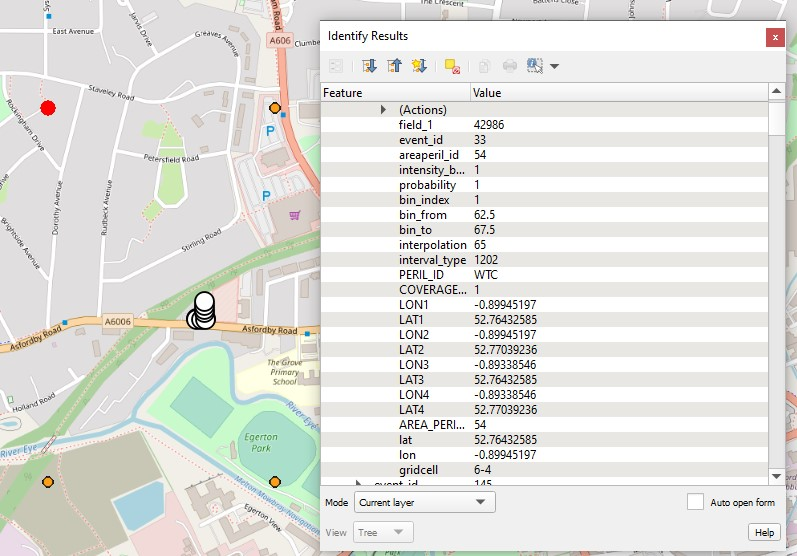

In [27]:
# first read in event footprints with their associated hazard intensities
area_peril_dictionary = pd.read_csv("../keys_data/PiWind/areaperil_dict.csv")
intensity_bin_dictionary = pd.read_csv("../model_data/PiWind/intensity_bin_dict.csv")
footprints = pd.read_csv("../model_data/PiWind/footprint.csv")

footprints_with_hazard = footprints.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_id', right_on='bin_index').merge(
    area_peril_dictionary, how='inner', 
    left_on='areaperil_id', right_on='AREA_PERIL_ID')

# now filter for areaperil_id = 54
a54 = footprints_with_hazard[(footprints_with_hazard['areaperil_id'] == 54)]

a54.head()
# there appear to be two identical intensity readings for the same area for each event 
# so let us drop the duplicate event_ids
# and just keep the columns we need
haz = (a54.drop_duplicates(subset='event_id')
                  .sort_values(['event_id'])
                    .iloc[:, :3])

print(len(haz))
haz.head()       

365


,event_id,areaperil_id,intensity_bin_id
43030,1,54,2
43432,2,54,12
43616,3,54,23
43482,5,54,14
43674,12,54,7


In [28]:
# now we conveniently already have a single intensity_bin_id for each event
# to model losses we must combine the intensities with our vulnerability data
# AND sample random numbers to determine by event by location losses

# read in our vulnerability data
vs = v_mat[(v_mat['vulnerability_id'] == 1)]

vs.head()

,vulnerability_id,intensity_bin_id,damage_bin_id,probability
0,1.0,1,1,0.008621
1,1.0,1,2,0.250000
2,1.0,1,3,0.405172
3,1.0,1,4,0.336207
4,1.0,2,2,0.051020


In [29]:
# merge the hazard and vulnerability data together
# so we know the full range of possible damage outcomes and the probabiility of each
hv = (pd.merge(haz,vs,on='intensity_bin_id', how='left'))

print(len(hv))
hv.head()

1424


,event_id,areaperil_id,intensity_bin_id,vulnerability_id,damage_bin_id,probability
0,1,54,2,1.0,2,0.051020
1,1,54,2,1.0,3,0.295918
2,1,54,2,1.0,4,0.397959
3,1,54,2,1.0,5,0.255102
4,2,54,12,1.0,7,0.156863


In [30]:
# now determine the damage severity for each intensity bin/event combination
# by comparing the the cumulative probability of each damage level occuring against a random number

hvd = hv.groupby(['event_id','intensity_bin_id']).apply(
        # calculate cumulative probability of succesively more severe levels of damage occurring
        lambda x: x.assign(cum_prob=x['probability'].cumsum(),
                           # generate random number between 0 and 1
                           r=np.random.uniform())
                    # keep only the rows that where r <= to cum_prob
                     .query('r <= cum_prob')
                    # and keep only the first row per event where cum_prob is >= r
                     .drop_duplicates('event_id', keep='first')
        ).reset_index(drop=True)

print(len(hvd), 'damage outcomes should match',len(haz),'events')

hvd.head()

365 damage outcomes should match 365 events


,event_id,areaperil_id,intensity_bin_id,vulnerability_id,damage_bin_id,probability,cum_prob,r
0,1,54,2,1.0,2,0.051020,0.051020,0.009136
1,2,54,12,1.0,10,0.225490,1.000000,0.995982
2,3,54,23,1.0,10,0.263636,0.318182,0.087974
3,5,54,14,1.0,9,0.359223,0.514563,0.284301
4,12,54,7,1.0,8,0.600000,1.000000,0.682148


In [31]:
# now to finally calculate losses we simply relate our damage bins to a loss fraction
# using the PiWind damage bin dictionary

hvd2 = hvd.rename(columns={'damage_bin_id':'bin_index'})

losses = (pd.merge(hvd2,dbd[['bin_index','interpolation']],on='bin_index', how='left')
         .rename(columns={'interpolation':'loss_frac'}))

# and multipy the loss fraction by the sum of total insured value (TIV) of one of all the properties - lets take the first one
# this will give us the "ground up loss" (total loss not considering insurance policy conditons)

# note that we can take this shortcut of summing the TIV 
# only because all buildings have the same vulnerability and are in the same gridcell of each hazard footprint

total_TIV = sum(exp['BuildingTIV']) # sum total value of 3.4 million GBP (pounds)

losses['GUPLoss'] = losses['loss_frac']*total_TIV
losses.head()

,event_id,areaperil_id,intensity_bin_id,vulnerability_id,bin_index,probability,cum_prob,r,loss_frac,GUPLoss
0,1,54,2,1.0,2,0.051020,0.051020,0.009136,0.05,170000.0
1,2,54,12,1.0,10,0.225490,1.000000,0.995982,0.85,2890000.0
2,3,54,23,1.0,10,0.263636,0.318182,0.087974,0.85,2890000.0
3,5,54,14,1.0,9,0.359223,0.514563,0.284301,0.75,2550000.0
4,12,54,7,1.0,8,0.600000,1.000000,0.682148,0.65,2210000.0


## Summary of losses - Average Annual Loss

The AAL is a simple but powerful summary statistic that (re)insurance companies use to guide their risk pricing. Essentially if the AAL for a location or a portfolio is higher than the annual premiums received for insuring these risks then the insurer can expect to lose money (on average over long periods of time).

In [32]:
# the AAL for this portfolio can now be simply calculated by dividing the grand total of GUPLoss
# by the number of years in the PiWind event catalogue

# read in occurence file
occ = pd.read_csv("../model_data/PiWind/occurrence_lt.csv")

# assume that the final year of the event set is equal to the length of the catalogue
n_years = max(occ['occ_year'])

print(n_years, 'years in event catalogue')
print("\n",occ.tail(1))

# then divide the grand total loss by the number of years
GT_loss = sum(losses['GUPLoss']) # 625 billion
AAL = GT_loss/n_years

1000 years in event catalogue

       event_id  period_no  occ_year  occ_month  occ_day
1447      1448       1000      1000          1        1


In [33]:
print("When using our new vulnerability matrix in the PiWind model\nthe AAL for their 10 locations is:\n\n",  "£{:,.0f}".format(AAL))

When using our new vulnerability matrix in the PiWind model
the AAL for their 10 locations is:

 £623,730


### We can now rerun the same code on the original PiWind vulnerability data

In [34]:
# All 10 locations in PiWind conveniently use the same vulnerabilty function
# Vulnerability_ID 2

# read in PiWind vulnerability data
vs = vulnerabilities[(vulnerabilities['vulnerability_id'] == 2)]

vs.head()

,vulnerability_id,intensity_bin_id,damage_bin_id,probability
179,2,1,1,0.638
180,2,1,2,0.176
181,2,1,3,0.088
182,2,1,4,0.053
183,2,1,5,0.041


In [35]:
# merge the hazard and vulnerability data together
# so we know the full range of possible damage outcomes and the probabiility of each
hv = (pd.merge(haz,vs,on='intensity_bin_id', how='left'))

print(len(hv))


2324


In [36]:
# now determine the damage severity for each intensity bin/event combination
# by comparing the the cumulative probability of each damage level occuring against a random number

hvd = hv.groupby(['event_id','intensity_bin_id']).apply(
        # calculate cumulative probability of succesively more severe levels of damage occurring
        lambda x: x.assign(cum_prob=x['probability'].cumsum(),
                           # generate random number between 0 and 1
                           r=np.random.uniform())
                    # keep only the rows that where r <= to cum_prob
                     .query('r <= cum_prob')
                    # and keep only the first row per event where cum_prob is >= r
                     .drop_duplicates('event_id', keep='first')
        ).reset_index(drop=True)

print(len(hvd), 'damage outcomes should match',len(haz),'events')

365 damage outcomes should match 365 events


In [37]:
# now to finally calculate losses we simply relate our damage bins to a loss fraction
# using the PiWind damage bin dictionary

hvd2 = hvd.rename(columns={'damage_bin_id':'bin_index'})

losses = (pd.merge(hvd2,dbd[['bin_index','interpolation']],on='bin_index', how='left')
         .rename(columns={'interpolation':'loss_frac'}))

# and multipy the loss fraction by the sum of total insured value (TIV) of one of all the properties - lets take the first one
# this will give us the "ground up loss" (total loss not considering insurance policy conditons)

# note that we can take this shortcut of summing the TIV 
# only because all buildings have the same vulnerability and are in the same gridcell of each hazard footprint

total_TIV = sum(exp['BuildingTIV']) # sum total value of 3.4 million GBP (pounds)

losses['GUPLoss'] = losses['loss_frac']*total_TIV

## Summary of losses - Average Annual Loss - PiWind original vulnerability


In [38]:
# the AAL for this portfolio can now be simply calculated by dividing the grand total of GUPLoss
# by the number of years in the PiWind event catalogue

# read in occurence file
occ = pd.read_csv("../model_data/PiWind/occurrence_lt.csv")

# assume that the final year of the event set is equal to the length of the catalogue
n_years = max(occ['occ_year'])

print(n_years, 'years in event catalogue')
print("\n",occ.tail(1))

# then divide the grand total loss by the number of years
piGT_loss = sum(losses['GUPLoss']) # 625 billion
piAAL = piGT_loss/n_years

1000 years in event catalogue

       event_id  period_no  occ_year  occ_month  occ_day
1447      1448       1000      1000          1        1


In [39]:
print("When using the PiWind vulnerability matrix \nthe AAL for their 10 locations is:\n\n",  "£{:,.0f}".format(piAAL))

When using the PiWind vulnerability matrix 
the AAL for their 10 locations is:

 £121,040


After running the above loss analysis several times (taking several samples of losses), the AAL values produced were consistently around half the AAL value generated by running the same analysis in the OASIS user interface (see figure below).

This is likely because we removed half of the events (all those that were exact duplicates of each other) whilst running our analysis. Whilst the UI likely uses 730 events by independently modelling damage from each of the 365 unique events twice. 

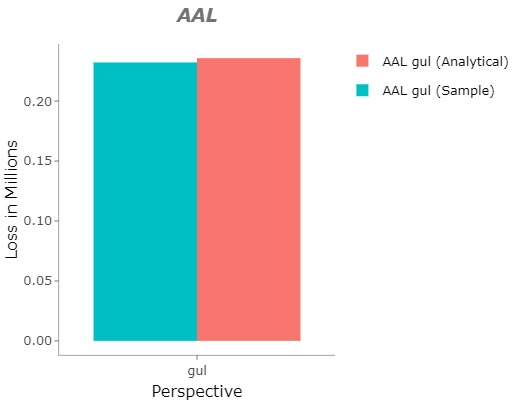

### The Remainder of this Jupyter notebook contains the origianl code to run the above loss analysis using the Oasis Loss Modelling Framework directly.

Running the next code cell however will overwrite the orignial vulnerability.csv fileat the PiWind model uses and replace it with the one we have developed above, allowing the user to test if it works.

In [40]:
# overwrite the orignial vulnerability.csv used in PiWind with out new vulnerability matrices
# note tha a backup of the original has already been made in the same file directory - so the earlier code can be rerun

v_mat.to_csv('../model_data/PiWind/vulnerability.csv', index=False)

In [41]:
area_peril_dictionary = pd.read_csv("../keys_data/PiWind/areaperil_dict.csv")
area_peril_dictionary.head()

,PERIL_ID,COVERAGE_TYPE,LON1,LAT1,LON2,LAT2,LON3,LAT3,LON4,LAT4,AREA_PERIL_ID
0,WSS,1,-0.917651,52.733993,-0.917651,52.740060,-0.911585,52.733993,-0.911585,52.740060,101
1,WSS,3,-0.917651,52.733993,-0.917651,52.740060,-0.911585,52.733993,-0.911585,52.740060,101
2,WTC,3,-0.917651,52.733993,-0.917651,52.740060,-0.911585,52.733993,-0.911585,52.740060,1
3,WTC,1,-0.917651,52.733993,-0.917651,52.740060,-0.911585,52.733993,-0.911585,52.740060,1
4,WSS,1,-0.917651,52.740060,-0.917651,52.746126,-0.911585,52.740060,-0.911585,52.746126,111


Lets plot the area peril cells on a map of the UK. For this model, the area perils are a simple uniform grid in a square.

In [42]:
m = folium.Map(location=[	52.737027, -0.914618], zoom_start=11, tiles='cartodbpositron')
area_peril_dictionary['lat']=area_peril_dictionary['LAT1']
area_peril_dictionary['lon']=area_peril_dictionary['LON1']
num_cells = area_peril_dictionary.lat.count()
num_cells_per_side = math.sqrt(num_cells)
cell_size_lat = (max(area_peril_dictionary.lat) - min(area_peril_dictionary.lat)) / (num_cells_per_side - 1)
cell_size_lon = (max(area_peril_dictionary.lon) - min(area_peril_dictionary.lon)) / (num_cells_per_side - 1)
for i, row in area_peril_dictionary.iterrows():
    geometry = [Polygon([
        (row.lon, row.lat),
        (row.lon, row.lat + cell_size_lat),
        (row.lon + cell_size_lon, row.lat + cell_size_lat),
        (row.lon + cell_size_lon, row.lat)])]        
    crs = 'epsg:4326'
    d = {'Description': ['All']}
    df = pd.DataFrame(data=d)
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    folium.GeoJson(gdf).add_to(m)
    
m.save("piwind_extent_map.html")

In [43]:
# %%HTML
# <iframe width="100%" height=350 src="piwind_extent_map.html"></iframe>

Lets have a look at the data contained in the Intensity Bin dictionary file. 
Note that the dictionary is only meta-data, and not required for model execution.

In [44]:
intensity_bin_dictionary = pd.read_csv("../model_data/PiWind/intensity_bin_dict.csv")
intensity_bin_dictionary.head()

,bin_index,bin_from,bin_to,interpolation,interval_type
0,1,62.5,67.5,65.0,1202
1,2,67.5,72.5,70.0,1202
2,3,72.5,77.5,75.0,1202
3,4,77.5,82.5,80.0,1202
4,5,82.5,87.5,85.0,1202


Lets have a look at the data contained in the footprint file. 

In [45]:
footprints = pd.read_csv("../model_data/PiWind/footprint.csv")
footprints.head()

,event_id,areaperil_id,intensity_bin_id,probability
0,1,3,1,1.0
1,1,4,2,1.0
2,1,5,2,1.0
3,1,6,3,1.0
4,1,7,3,1.0


Lets visualize the first 5 event footprints.

/var/folders/m0/kkzly5c16x36wjqhty_t4zrh0000gn/T/ipykernel_25641/2848261788.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), vmin=vmin, vmax=vmax,


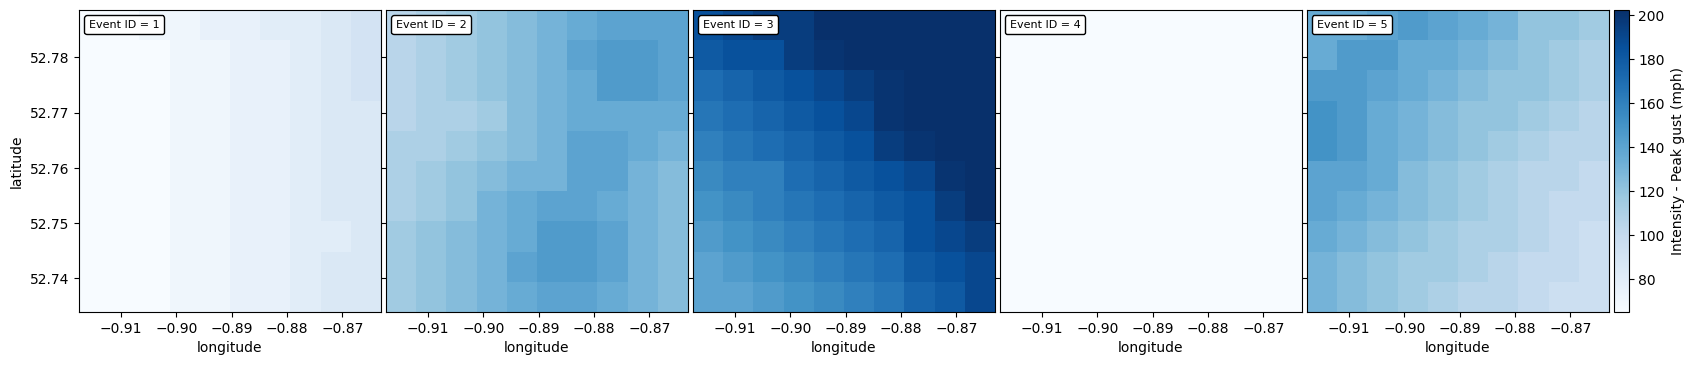

In [46]:
area_peril_dictionary['gridcell'] = area_peril_dictionary['AREA_PERIL_ID'].apply(
    lambda ap: str(int((ap-1)/10)+1)+"-"+str(ap-(int((ap-1)/10))*10))

footprints_with_hazard = footprints.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_id', right_on='bin_index').merge(
    area_peril_dictionary, how='inner', 
    left_on='areaperil_id', right_on='AREA_PERIL_ID')

footprints_with_hazard = footprints_with_hazard[footprints_with_hazard['PERIL_ID']=='WTC']
footprints_with_hazard = footprints_with_hazard[footprints_with_hazard['COVERAGE_TYPE']==1]

fig = plt.figure(figsize=(20,10))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 5),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

vmin = min(footprints_with_hazard.interpolation)
vmax = max(footprints_with_hazard.interpolation)
for idx, ax in enumerate(grid):
    a = np.zeros([10, 10])
    for __, row in footprints_with_hazard[footprints_with_hazard.event_id == idx+1].iterrows():
        i, j = row.gridcell.split('-')
        a[10-int(i), int(j)-1] = row.interpolation
    im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), vmin=vmin, vmax=vmax,
                   extent=(
                       min(area_peril_dictionary.lon), max(area_peril_dictionary.lon), 
                       min(area_peril_dictionary.lat), max(area_peril_dictionary.lat)))
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    at = AnchoredText(
        "Event ID = {}".format(idx + 1),
        prop=dict(size=8),
        frameon=True,
        loc=2,
    )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

grid[0].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Intensity - Peak gust (mph)")

plt.show()

Lets have a look at the data contained in the Damage Bin dictionary file. 
Note that the dictionary is required for model execution.

In [47]:
damage_bin_dictionary = pd.read_csv("../model_data/PiWind/damage_bin_dict.csv")
damage_bin_dictionary.head()

,bin_index,bin_from,bin_to,interpolation,interval_type
0,1,0.0,0.0,0.00,1203
1,2,0.0,0.1,0.05,1200
2,3,0.1,0.2,0.15,1202
3,4,0.2,0.3,0.25,1202
4,5,0.3,0.4,0.35,1202


Lets have a look at the data contained in the Vulnerability file. 

In [48]:
vulnerabilities = pd.read_csv("../model_data/PiWind/vulnerability.csv")
vulnerabilities.head()

,vulnerability_id,intensity_bin_id,damage_bin_id,probability
0,1.0,1,1,0.008621
1,1.0,1,2,0.250000
2,1.0,1,3,0.405172
3,1.0,1,4,0.336207
4,1.0,2,2,0.051020


The model has seperate vulnerability curves for Residential, Commerical and Industrial occupancies. 
Lets visualise these curves.

/var/folders/m0/kkzly5c16x36wjqhty_t4zrh0000gn/T/ipykernel_25641/2532181581.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), vmin=vmin, vmax=vmax,


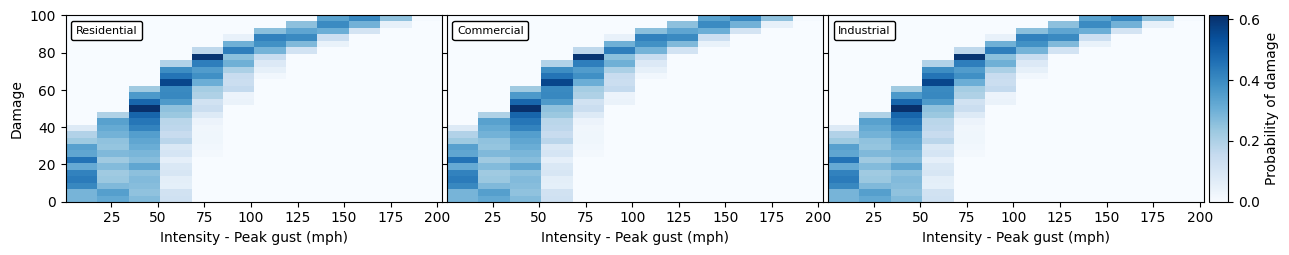

In [49]:
vulnerabilities_with_hazard_and_damage = vulnerabilities.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_id', right_on='bin_index').merge(
    damage_bin_dictionary, how='inner',
    suffixes=["_i", "_d"], left_on='damage_bin_id', right_on='bin_index')

fig = plt.figure(figsize=(15,30))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

vmin = 0.0
vmax = max(vulnerabilities_with_hazard_and_damage.probability)
labels = ["Residential", "Commercial", "Industrial"]
for idx, ax in enumerate(grid):
    a = np.zeros((29, 12))
    for index, row in vulnerabilities_with_hazard_and_damage[
        vulnerabilities_with_hazard_and_damage.vulnerability_id == idx + 1].iterrows():
        a[int(row.bin_index_i-1), 11-int(row.bin_index_d-1)] = row.probability
    
    im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), vmin=vmin, vmax=vmax,
                   extent=(
                       min(intensity_bin_dictionary.interpolation), max(intensity_bin_dictionary.interpolation), 
                       min(damage_bin_dictionary.interpolation) * 100, max(damage_bin_dictionary.interpolation) * 100))

    at = AnchoredText(labels[idx],
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    ax.set_xlabel("Intensity - Peak gust (mph)")
    ax.set_ylabel("Damage")

grid[0].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Probability of damage")


plt.show()

To run the model we need some test exposure data. Lets have a look at an example Location and Account file. 

In [50]:
test_locations = pd.read_csv('../tests/inputs/SourceLocOEDPiWind.csv')
test_locations.head()

,PortNumber,AccNumber,LocNumber,IsTenant,BuildingID,CountryCode,Latitude,Longitude,StreetAddress,PostalCode,OccupancyCode,ConstructionCode,LocPerilsCovered,BuildingTIV,OtherTIV,ContentsTIV,BITIV,LocCurrency,OEDVersion
0,1,A11111,100030534294,1,1,GB,52.777460,-0.900023,1 ABINGDON ROAD,LE13 0SA,1050,5000,WW1,150000,0,37500,15000,GBP,2.0.0
1,1,A11111,100030534295,1,1,GB,52.778002,-0.900320,2 ABINGDON ROAD,LE13 0SB,1050,5000,WW1,150000,0,37500,15000,GBP,2.0.0
2,1,A11111,100030534296,1,1,GB,52.777217,-0.900014,3 ABINGDON ROAD,LE13 0SA,1050,5000,WW1,125000,0,31250,12500,GBP,2.0.0
3,1,A11111,100030534297,1,1,GB,52.777970,-0.900721,4 ABINGDON ROAD,LE13 0SB,1050,5000,WW1,150000,0,37500,15000,GBP,2.0.0
4,1,A11111,100030534298,1,1,GB,52.777091,-0.900017,5 ABINGDON ROAD,LE13 0SA,1050,5000,WW1,150000,0,37500,15000,GBP,2.0.0


In [51]:
test_accounts = pd.read_csv('../tests/inputs/SourceAccOEDPiWind.csv')
test_accounts.head()

,PortNumber,AccNumber,AccCurrency,PolNumber,PolPerilsCovered,PolInceptionDate,PolExpiryDate,LayerNumber,LayerParticipation,LayerLimit,LayerAttachment,OEDVersion
0,1,A11111,GBP,Layer1,WW1,2018-01-01,2018-12-31,1,0.3,5000000,500000,2.0.0
1,1,A11111,GBP,Layer2,WW1,2018-01-01,2018-12-31,2,0.3,100000000,5500000,2.0.0


To run the model, we also need to define some analysis settings. Lets have a look at an example settings file.

In [52]:
with open('../analysis_settings.json', 'r') as myfile:
    analysis_settings=json.loads(myfile.read().replace('\n', ''))
print(json.dumps(analysis_settings, indent=True))

{
 "version": "3",
 "analysis_tag": "base_example",
 "source_tag": "MDK",
 "model_name_id": "PiWind",
 "model_supplier_id": "OasisLMF",
 "gul_threshold": 0,
 "gul_output": true,
 "model_settings": {
  "event_set": "p",
  "event_occurrence_id": "lt"
 },
 "gul_summaries": [
  {
   "aalcalc": true,
   "eltcalc": true,
   "id": 1,
   "lec_output": true,
   "leccalc": {
    "full_uncertainty_aep": true,
    "full_uncertainty_oep": true,
    "return_period_file": true
   }
  }
 ],
 "il_output": true,
 "il_summaries": [
  {
   "aalcalc": true,
   "eltcalc": true,
   "id": 1,
   "lec_output": true,
   "leccalc": {
    "full_uncertainty_aep": true,
    "full_uncertainty_oep": true,
    "return_period_file": true
   }
  }
 ],
 "ri_output": true,
 "ri_summaries": [
  {
   "aalcalc": true,
   "eltcalc": true,
   "id": 1,
   "lec_output": true,
   "leccalc": {
    "full_uncertainty_aep": true,
    "full_uncertainty_oep": true,
    "return_period_file": true
   }
  }
 ]
}


We can now run the model using the Oasis MDK.

In [53]:
! rm -rf /tmp/analysis_test
! oasislmf model run -C ../oasislmf.json -r /tmp/analysis_test


Stating oasislmf command - RunModel
RUNNING: oasislmf.manager.interface
  0%|                                                     | 0/2 [00:00<?, ?it/s]
Processing arguments - Creating Oasis Files

Generating Oasis files (GUL=True, IL=True, RIL=True)
RUNNING: oasislmf.lookup.factory.generate_key_files
  0%|                                                     | 0/2 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/opt/anaconda3/envs/oasis_3.10_proj/bin/oasislmf", line 7, in <module>
    sys.exit(RootCmd().run())
  File "/opt/anaconda3/envs/oasis_3.10_proj/lib/python3.10/site-packages/oasislmf/cli/root.py", line 41, in run
    return super(OasisBaseCommand, self).run(args=args)
  File "/opt/anaconda3/envs/oasis_3.10_proj/lib/python3.10/site-packages/argparsetree/cmd.py", line 159, in run
    return cmd_cls(sub_command_name).run(args)
  File "/opt/anaconda3/envs/oasis_3.10_proj/lib/python3.10/site-packages/argparsetree/cmd.py", line 159, in run
    return cmd_cls(sub_command_n

Lets visualize the output of our analysis.

In [55]:
analysis_directory = "/tmp/analysis_test"
gul_aep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_aep.csv"))
gul_aep = gul_aep[gul_aep.type == 1]
gul_oep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_oep.csv"))
gul_oep = gul_oep[gul_oep.type == 1]
eps = pd.merge(gul_oep, gul_aep, on=["summary_id", "return_period"], suffixes=["_oep", "_aep"])
eps = eps.sort_values(by="return_period", ascending=True)
fig, ax = plt.subplots()
eps.plot(ax=ax, kind='bar', x='return_period', y=["loss_oep", "loss_aep"])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xticklabels(['{:,}'.format(int(x)) for x in eps.return_period])
plt.legend(('OEP', 'AEP'))
ax.set_xlabel("Return period (years)")
ax.set_ylabel("Loss")